In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd
import jax_cosmo as jc
import numpy
import matplotlib.pyplot as plt

In [2]:
from jax.config import config
config.update("jax_debug_nans", True)

In [182]:
def L_sn(wl):
    wl0=5500.
    sig2 = 1e6
    print(jnp.exp(-(wl-wl0)**2/2/sig2))
    return jnp.exp(-(wl-wl0)**2/2/sig2)

In [183]:
def CCM_single(wl, Rv):
    def infrared(x, Rv):
        a = 0.574*x**1.61
        b = -0.527*x**1.61
        return a+b/Rv

    def optical(x, Rv):
        y=x-1.82
        a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4+ 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
        b = 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7
        return a+b/Rv

    def ultraviolet(x, Rv):
        a = 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341)
        b = -3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263)
        return a+b/Rv
        
    x = 1e4/wl
    return jnp.select(condlist=[(x >= 0.3) & (x<=1.1), (x >= 1.1) & (x<=3.3), (x >= 3.3) & (x<=5.9)],
                                choicelist=[infrared(x,Rv), optical(x,Rv), ultraviolet(x,Rv)], default=0.)

In [184]:
def CCM(wl,Rv):
    return vmap(CCM_single,(0,None))(wl,Rv)

In [243]:
def flux_single(efflam, Av, Rv, z, cosmo):
    dl = (1+z)**2*jc.background.angular_diameter_distance(cosmo, 1/(1+z))
    # print("single ",efflam, Av, Rv, z, cosmo)
    restlam = efflam/(1+z)
    print(dl, L_sn(restlam))
    return 1/4/numpy.pi/dl**2 * L_sn(restlam) * 10**(-Av/2.5)*CCM_single(efflam, Rv)

In [244]:
def flux_lam(efflam, Av, Rv, z, cosmo):
    # print("lam ",efflam, Av, Rv, z, cosmo)
    return vmap(flux_single,(0, None, None, None, None))(efflam, Av, Rv, z, cosmo)

In [245]:
def flux_all(efflam, Av, Rv, z, cosmo):
    # print("all ",efflam, Av, Rv, z, cosmo)
    return vmap(flux_lam,(None, 0, 0, 0, None))(efflam, Av, Rv, z, cosmo)

In [246]:
def lnL(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,fs, fsigs, efflam):
    cosmo = jc.Planck15(Omega_c=Omega_c, w0=w0, wa=wa)
    flux = flux_all(efflam+dlams, Avs, Rvs, zs, cosmo)
    flux = flux * fwidth
    
    fluxterm = jnp.sum((fs-flux)**2 /(fsigs**2 + (numpy.log(10)/2.5*flux*dm_int)**2))

    calterm = jnp.sum(dlams**2*1e-4) + jnp.sum((1-fwidth)**2*1e-4)
    #actually 2lnL
    return fluxterm+calterm

In [247]:
def hessianlnL(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,fs, fsigs, efflam):
    return jacfwd(grad(lnL))(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,fs, fsigs, efflam)
    

In [251]:
def simulate_flux(nsn = 2, dm_int = 0.1, dm_obs = 0.02, cosmo = jc.Planck15(), efflam = numpy.array([4700., 6420.,  7849.])):

    nlam = len(efflam)
    
    zs = numpy.linspace(0.4,1,nsn)
    Avs = numpy.random.uniform(0,0.001,nsn)
    Rvs = numpy.random.uniform(2,3.5,nsn)
    
    flux = flux_all(efflam,Avs,Rvs,zs,cosmo)
    dflux = numpy.log(10)/2.5 * flux * numpy.sqrt(dm_int**2 + dm_obs**2)
    flux = numpy.random.normal(flux, dflux)
    return zs, flux, numpy.log(10)/2.5 * flux * dm_obs, efflam, Avs, Rvs, dm_int, cosmo

In [252]:
zs, flux, dflux, efflam, Avs, Rvs, dm_int, cosmo = simulate_flux()

Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
    val = Array([[0.10066889, 0.65838915, 0.99435246],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0
Traced<ShapedArray(float32[1])>with<BatchTrace(level=1/0)> with
  val = Array([[1517.7845],
       [4605.452 ]], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
    val = Array([[0.10066889, 0.65838915, 0.99435246],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0
Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
    val = Array([[0.10066889, 0.65838915, 0.99435246],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0


In [250]:
lnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)

Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
    val = Array([[0.10066889, 0.65838915, 0.99435246],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0
Traced<ShapedArray(float32[1])>with<BatchTrace(level=1/0)> with
  val = Array([[1517.7845],
       [4605.452 ]], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
    val = Array([[0.10066889, 0.65838915, 0.99435246],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0
Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
    val = Array([[0.10066889, 0.65838915, 0.99435246],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0


Array(5.2168164, dtype=float32)

In [242]:
grad(lnL, argnums=0)(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)

Traced<ShapedArray(float32[])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=3/0)> with
    val = Array([[0.10066889, 0.65838915, 0.99435246],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0


FloatingPointError: invalid value (nan) encountered in jit(add)

In [126]:
def D_A(Omega_c,zs):
    cosmo = jc.Planck15(Omega_c=Omega_c)
    da = jc.background.angular_diameter_distance(cosmo, 1/(1+zs))
    return jnp.sum(1/da**2)

In [127]:
D_A(0.3,zs)

Array(1.4956572e-05, dtype=float32)

In [137]:
hessianlnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)

Traced<ShapedArray(float32[])>with<BatchTrace(level=6/0)> with
  val = Traced<ShapedArray(float32[3])>with<BatchTrace(level=5/0)> with
    val = Array([[0.47090474, 0.94500023, 0.26253894],
       [0.00700417, 0.07265376, 0.28906605]], dtype=float32)
    batch_dim = 0
  batch_dim = 0
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(add)

In [88]:
grad(D_A)(0.3,zs)

Array(3.005086e-06, dtype=float32, weak_type=True)

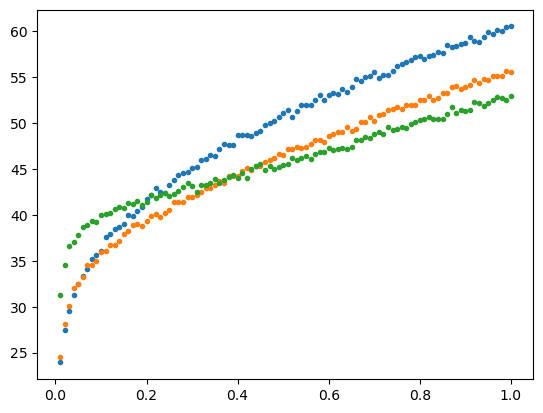

In [59]:
plt.plot(zs,-2.5*numpy.log(flux[:,:,0]),'.')

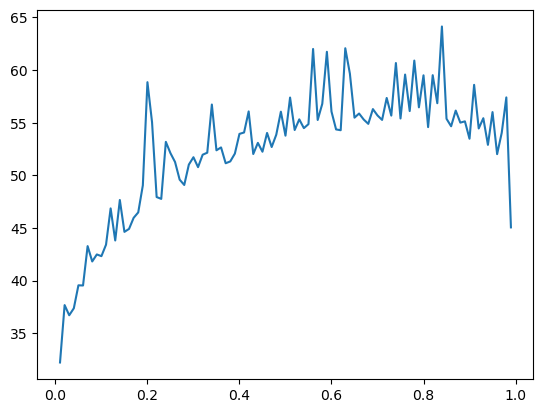

In [66]:
plt.plot(zs, -2.5*numpy.log(flux_sn(5000,Avs,Rvs,zs,cosmo)))

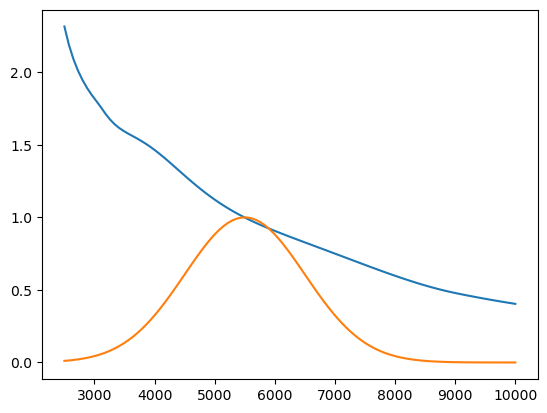

In [55]:
plt.plot(wl,CCM(wl,3.1))
plt.plot(wl,L_sn(wl))